This notebook showcases the functionality of `galCIB`. 

In [1]:
import numpy as np
import galCIB

import matplotlib.pyplot as plt

`galCIB` is a tool that calculates the expected galaxy x galaxy, galaxy x CIB and CIB x CIB power spectra (3D or 2D), given certain parameters. 

It is a highly flexible model that uses a halo-model approach to connect physical properties of interest such as the cosmic star formation history, halo dust temperature, galaxy halo properties, etc. with the observed power spectra. 

Currently, the default mode calculates the projected 2D power spectra, $C(\ell)$, given these parameters. Mathematically, our model appears as follows: 

\begin{equation}
    C_{\rm XY} (\ell) = \int_{z_{\rm min}}^{z_{\rm max}} \frac{dz}{c} \frac{H(z)}{\chi^2(z)} W_{\rm X} (z) W_{\rm Y} (z) P_{\rm XY} \left( k = \frac{\ell + 1/2}{\chi}, z \right)
\end{equation}

where, the left-hand side is our predicted cross-correlation between two fields, $X$ and $Y$; in our case {$X$,$Y$} $\in$ {galaxy, CIB}. 

Below we describe component-by-component, how each module calculates the ingredients of this function. 

- integral : `powerspectra.py` is the top-level module that takes all the ingredients on the right-hand side, and performs the integral. The main function in this module is `c_all` that takes in relevant parameters and outputs the 2D power spectra. 

- $\frac{1}{c} \frac{H(z)}{\chi^2(z)}$ : `consts.py` calculates these cosmological properties. As we are not varying cosmology, we only need to calculate these properties once, and the stored values are then used by other functions and modules as needed. 

- $W_{\rm X} (z) W_{\rm Y} (z)$ : `precalc.py` calculates these functions; they represent the radial distribution of the tracers (or fields), $X$ and $Y$. Given a survey, these are also fixed properties that only need to be calculated once. 

- $P_{\rm XY} \left( k = \frac{\ell + 1/2}{\chi}, z \right)$ : this represents the full 3D power spectra. `clustering` submodule has important functions that calculates ingredients necessary to calculate $P(k)$. The actual $P(k)$ is calculated inside `powerspectra.py`. Functions such as `cibgalcross_pk_2h` calculate it. 

Let's look at the docstring and the ingredients that go into calculating the 2D power spectra. 

In [2]:
from galCIB import powerspectra as ps

Note: redshifts have been re-sorted (earliest first)


/Users/tkarim/research/galCIB/src/galCIB/powerspectra.py:63: RuntimeWarning: divide by zero encountered in log10
  ELL_sampled = np.logspace(np.log10(consts.LMIN),
/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/numpy/core/function_base.py:157: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/numpy/core/function_base.py:167: RuntimeWarning: invalid value encountered in add
  y += start


In [3]:
ps.c_all??

Signature:
ps.c_all(
    theta,
    cib_model,
    num_channels=3,
    pz=None,
    mag_bias_alpha=None,
    gal_type='ELG',
)
Source:   
def c_all(theta, cib_model, num_channels=3,
          pz=None, mag_bias_alpha=None, gal_type = 'ELG'):
    """
    Returns C_gg, C_gCIB, C_CIBCIB.
    
    Args:
        theta : list of parameters 
        cib_model : 'M21' or 'Y23'
        num_channels : (int) number of CIB channels
        pz : (array) redshift distribution in probability density form 
        mag_bias_alpha : (float) galaxy mag bias
    Returns:
        c_all_combined : vectors of 10 power spectra vectors
                        [C_gg,
                         C_gx353, C_gx545, C_gx857,
                         C_353x353, C_545x545, C_857x857,
                         C_353x545, C_353x857, C_545x857,
                        ]
    """
    
    ## parameters 
    
    # gg, gx{CIB}, {CIB_nu X CIB_nu'}; this value is 1 + 3 + 6 = 10 for the default 3 channels
    num_of_unique_Cls = 1

For now the most important arguments are `theta` and `cib_model`. `theta` defines the parameters that our model needs to calculate the power spectra. `cib_model` takes the name of any pre-written CIB model in the module `cib.py`. This argument is important to properly parse the `theta` and pass parameters to relevant functions. 

In the future, we hope to make this step user-friendly, and allow the user to define their own `cib_model` in a way that `c_all` understands how to parse it and pass the relevant `theta` parameters as needed.

Right now we have a model called `M21` fully implemented, which is based on the [Maniyar+2021](https://arxiv.org/abs/2006.16329) paper. For this model, we have to input the parameters in the following way

In [4]:
# define fiducial values for M21 model

# 1- to 2- halo smoothing transition parameter is set to 1; but Mead++20 finds this to be 0.7 at z~0
hmalphas = np.ones(10) 

# shotnoise defined over log10 for sampling efficiency; 
# define as log10(N_shot/Jy/sr) = theta_shot;
# use unWISE green best-fit value because it is closest to ELG p(z)
shotnoise_gCIB = np.array([-1.8, -1.71, -2.24])
shotnoise_gCIB = shotnoise_gCIB - 2 # convert Y23 unit of 1e-8 MJy/sr to Jy/sr

# order is 353x353, 353x545, 353x857, 545x545, 545x857, 857x857
# taken from table 6 of 1309.0382, Planck 2013 CIB guesses
shotnoise_CIBCIB = np.log10(np.array([225, 543, 913, 1454, 2655, 5628]))
shotnoise_all = np.concatenate((shotnoise_gCIB, shotnoise_CIBCIB))

# physical parameters of importance
gal_params = np.array([5.47, 11.64, 0.30, 0.1, # Ncen (4): gamma, log10Mc, sigmaM, Ac
                       0.41, 11.20, 10**13.84 * (0.41)**(1/0.81), 0.81]) # Nsat (4): As, M0, M1, alpha
prof_params = np.array([0.58, 6.14, 0.67]) # fexp, tau, lambda_NFW
cib_params = np.array([0.49, 11.52, -0.02, 2.74, 0.5, 2.15, 11.38, 0.4]) # SFR (6): etamax, mu_peak0, mu_peakp, sigma_M0, tau, zc, Mmin_IR, IR_sigma_lnM

all_params = np.concatenate((hmalphas, shotnoise_all, gal_params, prof_params, cib_params))

In [5]:
c_m21 = ps.c_all(all_params, cib_model='M21')

you set meanIR to 1 by hand for testing.


Now we can inspect `c_m21`. It has the shape (Num. of Power Spectra, Number of angular scales). The order of the power spectra is: [$C_{gg}, C_{gI}, C_{I_1 I_2}$]. Here $I$ loops in [353, 545, 857], corresponding to the three frequency channels we observe CIB in. Additionally, $I_1 I_2$ loops in [353x353, 353x545, 353x857, 545x545, 545x857, 857x857]. 

In [6]:
c_m21.shape

(10, 3071)

We can plot these power spectra against angular scales. 

/var/folders/s2/zrtt0b094p52rpt0m42r4xmr0000gn/T/ipykernel_35004/2943516466.py:4: RuntimeWarning: divide by zero encountered in divide
  theta = 180/ells # angular scales in degrees


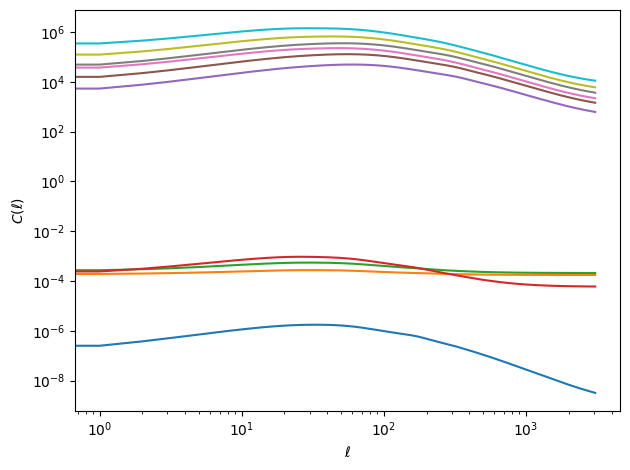

In [7]:
# Original x values

ells = np.arange(3071)
theta = 180/ells # angular scales in degrees

# Bottom x-axis (original)
for i in range(10):
    plt.loglog(ells, c_m21[i])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C(\ell)$')

plt.tight_layout()
plt.show()

The top $6$ curves represent the CIB x CIB, the next $3$ represent galaxy X CIB and the last one represent galaxy x galaxy power spectra respectively. 